In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import re
from collections import defaultdict


data_india_diabetes = pd.read_excel('../Case/ICMR-INDIAB Study.xlsx')
data_india_population = pd.read_excel('../Case/India Population (2011).xlsx')

In [5]:
data_india_diabetes = pd.read_excel('../Case/ICMR-INDIAB Study.xlsx')

get_lower = lambda x: [float(i.split(" ")[1][1:-1].split("–")[0]) for i in x]
get_upper = lambda x: [float(i.split(" ")[1][1:-1].split("–")[1]) for i in x]
get_mean = lambda x: [float(i.split(" ")[0]) for i in x]

def add_cols(data,cols):
    for col in cols:
        data.insert(1, f"{col} Max", get_upper(data[col]))
        data.insert(1, f"{col} Min", get_lower(data[col]))
        data.insert(1, f"{col} Mean", get_mean(data[col]))
        data.drop(col, axis=1, inplace=True)
    return data
data3 = add_cols(data_india_diabetes, ["Abdominal Obesity", "Generalized Obesity", "Hypertension", "Prediabetes", "Diabetes"])
# data3.to_excel("ICMR-INDIAB_modified.xlsx")

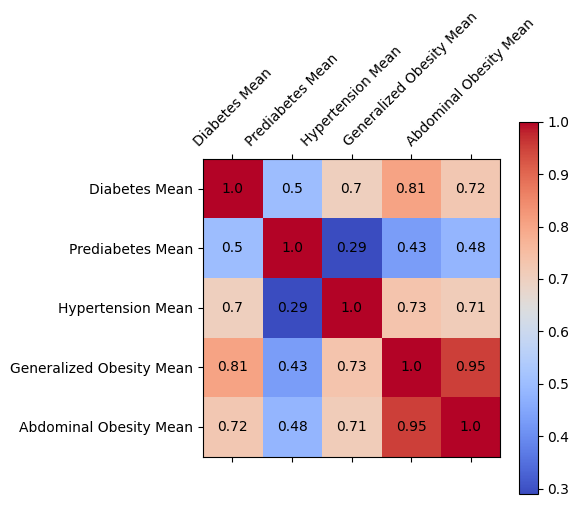

In [6]:
data1 = pd.read_excel("ICMR-INDIAB_modified.xlsx", index_col=0)
cols = ["Diabetes Mean", "Prediabetes Mean", "Hypertension Mean", "Generalized Obesity Mean", "Abdominal Obesity Mean"]
# with cols as labels:
plt.matshow(data1[cols].corr(), cmap='coolwarm')
plt.yticks(range(len(cols)), cols, rotation=0)
plt.xticks(range(len(cols)), cols, rotation=45)
# include numbers in the heatmap
for i in range(len(cols)):
    for j in range(len(cols)):
        plt.text(j, i, round(data1[cols].corr().values[i, j], 2), ha='center', va='center', color='black')
# make legend
plt.colorbar();

In [7]:
import pickle

# Load with:
with open("../Lucas/countries_population.pickle", "rb") as file:
    loaded_population_dict = pickle.load(file)
    
with open("../Lucas/countries_estimation.pickle", "rb") as file:
    loaded_estimation_dict = pickle.load(file)
    
loaded_population_dict["Côte d'Ivoire"] = loaded_population_dict["Ivory Coast"]
loaded_estimation_dict["Côte d'Ivoire"] = loaded_estimation_dict["Ivory Coast"]
loaded_population_dict.pop("Ivory Coast")
loaded_estimation_dict.pop("Ivory Coast")

loaded_population_dict["Guinea"] = loaded_population_dict["Guinea-Conakry"]
loaded_estimation_dict["Guinea"] = loaded_estimation_dict["Guinea-Conakry"]
loaded_population_dict.pop("Guinea-Conakry")
loaded_estimation_dict.pop("Guinea-Conakry")

[(14.79691, 6000.0, 88781.46), (7.46, 6000.0, 44760.0)]

In [12]:
data_new = pd.read_excel("../Case/Health Data from International Diabetes Foundation.xlsx", index_col=0, sheet_name=None, header=1)
data_undiag = data_new["People undiagnosed (1000s)"][["Country/Territory", 2021]]
data_diag = data_new["People with diabetes (1000s)"][["Country/Territory", 2021]]


import pickle
with open("../Lucas/india_states_population.pickle", "rb") as file:
    india_states_population = pickle.load(file)

india_diag = float((data_diag[data_diag["Country/Territory"] == "India"][2021].values[0]).replace(",",""))*1000
india_undiag = float((data_undiag[data_undiag["Country/Territory"] == "India"][2021].values[0]).replace(",",""))*1000

data1 = pd.read_excel("ICMR-INDIAB_modified.xlsx", index_col=0)

india_states_dicter = {}
for country in india_states_population.keys():
    diag_pop = data1.loc[data1["State"] == country, "Diabetes Mean"]/100 * india_states_population[country]
    undiag_pop = diag_pop * india_undiag / india_diag
    india_states_dicter[country] = ([float(diag_pop), float(undiag_pop)])

indistate = {c: (np.array(list(india_states_dicter.values()))*0.6)[i] for i, c in enumerate(india_states_dicter.keys())}

countries = india_states_population.keys()
df = len(countries)*[None]
for i, country in enumerate(countries):
    try:
        country_pop = india_states_population[country]
        country_diag = indistate[country][0] / country_pop
        country_undiag = indistate[country][1] / country_pop
        
        country_pop /= 1e8
        
        if country is None or country_diag is None or country_undiag is None:
            print(country, country_pop, country_diag, country_undiag)
        df[i] = [country, country_pop, country_diag, country_undiag]
    except:
        print(f"Error in {country}")
    
the_india_df = pd.DataFrame([i for i in df if i is not None], columns=["Country", "Population", "Diagnosed", "Undiagnosed"])
the_india_df.set_index("Country", inplace=True)
the_india_df.to_csv("india_states_data.csv")

C:\Users\alexa\AppData\Local\Temp\ipykernel_16400\1491629009.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  india_states_dicter[country] = ([float(diag_pop), float(undiag_pop)])


(8585508.81830621, 3333845.997967133)

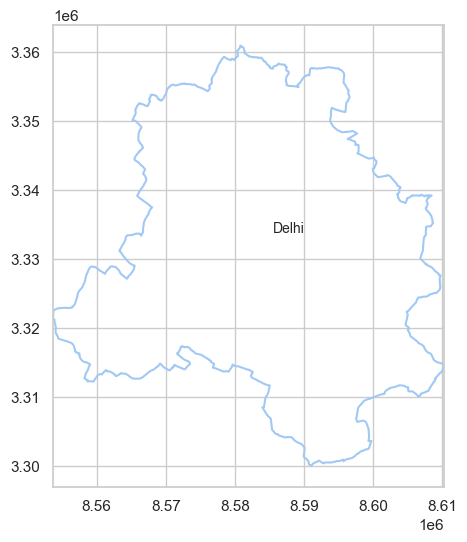

In [57]:
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.mpl.rc("figure", figsize=(10,6))

sf = shp.Reader("India_State_Boundary.dbf")

def read_shapefile(sf):
    #fetching the headings from the shape file
    fields = [x[0] for x in sf.fields][1:]
#fetching the records from the shape file
    records = [list(i) for i in sf.records()]
    shps = [s.points for s in sf.shapes()]
#converting shapefile data into pandas dataframe
    df = pd.DataFrame(columns=fields, data=records)
#assigning the coordinates
    df = df.assign(coords=shps)
    return df

df = read_shapefile(sf)

def plot_shape(id, s=None):
    plt.figure()
    #plotting the graphical axes where map ploting will be done
    ax = plt.axes()
    ax.set_aspect('equal')
#storing the id number to be worked upon
    shape_ex = sf.shape(id)
#NP.ZERO initializes an array of rows and column with 0 in place of each elements 
    #an array will be generated where number of rows will be(len(shape_ex,point))and number of columns will be 1 and stored into the variable
    x_lon = np.zeros((len(shape_ex.points),1))
#an array will be generated where number of rows will be(len(shape_ex,point))and number of columns will be 1 and stored into the variable
    y_lat = np.zeros((len(shape_ex.points),1))
    for ip in range(len(shape_ex.points)):
        x_lon[ip] = shape_ex.points[ip][0]
        y_lat[ip] = shape_ex.points[ip][1]
#plotting using the derived coordinated stored in array created by numpy
    plt.plot(x_lon,y_lat) 
    x0 = np.mean(x_lon)
    y0 = np.mean(y_lat)
    plt.text(x0, y0, s, fontsize=10)
# use bbox (bounding box) to set plot limits
    plt.xlim(shape_ex.bbox[0],shape_ex.bbox[2])
    return x0, y0

com_id = df[df["State_Name"] == "Delhi"]
plot_shape(com_id["coords"].index[0], "Delhi")

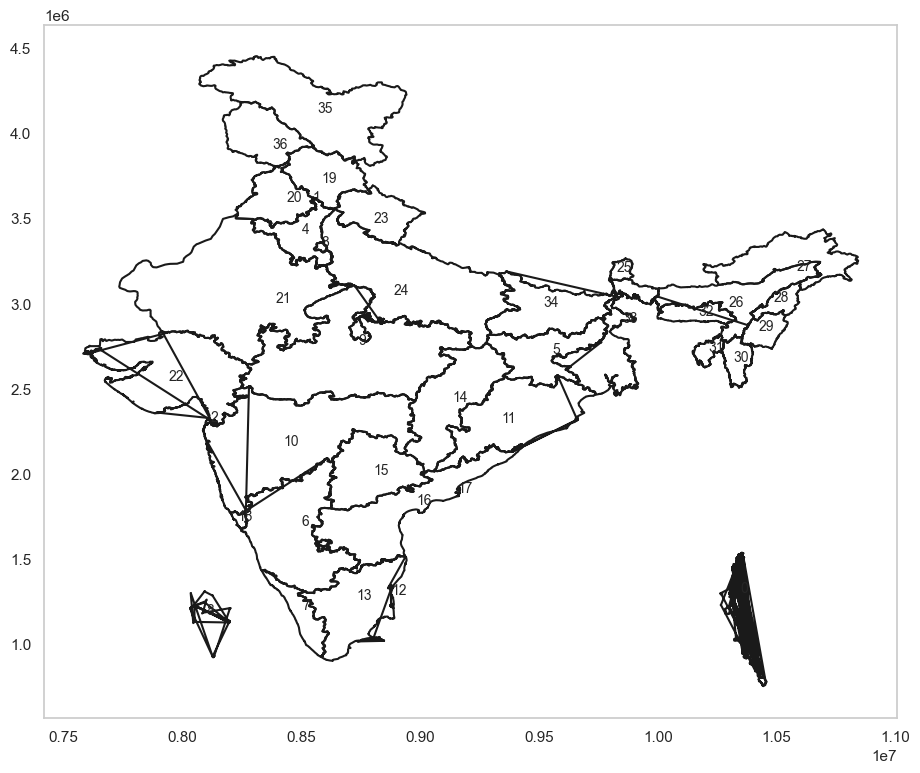

In [59]:
def plot_map(sf, x_lim = None, y_lim = None, figsize = (11,9)):
    plt.figure(figsize = figsize)
    id=0
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')
        
        if (x_lim == None) & (y_lim == None):
            x0 = np.mean(x)
            y0 = np.mean(y)
            plt.text(x0, y0, id, fontsize=10)
        id = id+1
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)
#calling the function and passing required parameters to plot the full map
plot_map(sf)
plt.grid(False)

In [71]:

import geopandas as gpd
map_df = gpd.read_file("india_country/India_State_Boundary.shp")
map_df["State_Name"]

In [85]:
names_indi = list(map_df["State_Name"])

In [98]:
def conv(x):
    try: 
        return india_states_population[x]
    except: return np.nan
map_df["Pop"] = map_df["State_Name"].apply(lambda x: conv(x))

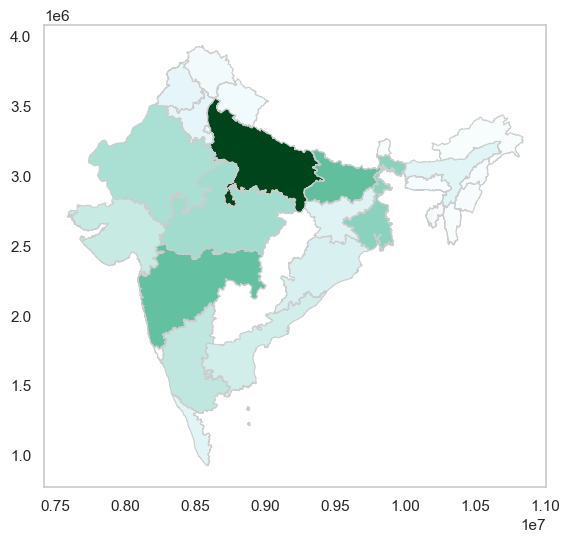

In [104]:
fig, ax = plt.subplots(1, figsize=(10, 6))
map_df.plot(column="Pop", cmap="BuGn", linewidth=0.8, ax=ax, edgecolor='0.8')
plt.grid(False)

In [111]:
list(map_df["State_Name"])

['Andaman & Nicobar',
 'Chandigarh',
 'Daman and Diu and Dadra and Nagar Haveli',
 'Delhi',
 'Haryana',
 'Jharkhand',
 'Karnataka',
 'Kerala',
 'Lakshadweep',
 'Madhya Pradesh',
 'Maharashtra',
 'Odisha',
 'Puducherry',
 'Tamilnadu',
 'Chhattishgarh',
 'Telengana',
 'Andhra Pradesh',
 'Puducherry',
 'Goa',
 'Himachal Pradesh',
 'Punjab',
 'Rajasthan',
 'Gujarat',
 'Uttarakhand',
 'Uttar Pradesh',
 'Sikkim',
 'Assam',
 'Arunachal Pradesh',
 'Nagaland',
 'Manipur',
 'Mizoram',
 'Tripura',
 'Meghalaya',
 'West Bengal',
 'Bihar',
 'Ladakh',
 'Jammu and Kashmir']

In [109]:
list(india_states_population)[15:]

['Maharashtra',
 'Manipur',
 'Meghalaya',
 'Mizoram',
 'Nagaland',
 'Odisha',
 'Puducherry',
 'Punjab',
 'Rajasthan',
 'Sikkim',
 'Tamil Nadu',
 'Telangana',
 'Tripura',
 'Uttar Pradesh',
 'Uttarakhand',
 'West Bengal']

In [105]:
map_df["State_Name"]

0                            Andaman & Nicobar
1                                   Chandigarh
2     Daman and Diu and Dadra and Nagar Haveli
3                                        Delhi
4                                      Haryana
5                                    Jharkhand
6                                    Karnataka
7                                       Kerala
8                                  Lakshadweep
9                               Madhya Pradesh
10                                 Maharashtra
11                                      Odisha
12                                  Puducherry
13                                   Tamilnadu
14                               Chhattishgarh
15                                   Telengana
16                              Andhra Pradesh
17                                  Puducherry
18                                         Goa
19                            Himachal Pradesh
20                                      Punjab
21           

In [15]:
countries = loaded_population_dict.keys()
# df = pd.DataFrame(["Country", "Population", "Diagnosed", "Undiagnosed"])
df = len(countries)*[None]
for i, country in enumerate(countries):
    try:
        country_pop = loaded_population_dict[country] * 1e8
        
        country_diag = data_diag[data_diag["Country/Territory"] == country][2021].values[0]
        country_diag = float(str(country_diag).replace(",", ""))*1000 / country_pop
        
        country_undiag = data_undiag[data_undiag["Country/Territory"] == country][2021].values[0]
        country_undiag = float(str(country_undiag).replace(",", ""))*1000 / country_pop
        
        country_pop /= 1e8
        
        if country is None or country_diag is None or country_undiag is None:
            print(country, country_pop, country_diag, country_undiag)
        df[i] = [country, country_pop, country_diag, country_undiag]
    except:
        print(f"Error in {country}")
    
the_df = pd.DataFrame([i for i in df if i is not None], columns=["Country", "Population", "Diagnosed", "Undiagnosed"])
the_df.set_index("Country", inplace=True)

0.26545864 0.012457684556810808 0.023385940649737372
0.26545864 0.012457684556810808 0.023385940649737372
0.26545864 0.012457684556810808 0.023385940649737372
0.26545864 0.012457684556810808 0.023385940649737372
0.26545864 0.012457684556810808 0.023385940649737372
0.26545864 0.012457684556810808 0.023385940649737372
0.16718971 0.02000123093699965 0.03564812690924579
0.16718971 0.02000123093699965 0.03564812690924579
0.16718971 0.02000123093699965 0.03564812690924579
0.16718971 0.02000123093699965 0.03564812690924579
0.06825445 0.02335378865407311 0.05803284621002734
0.06825445 0.02335378865407311 0.05803284621002734
0.06825445 0.02335378865407311 0.05803284621002734
0.3423205 0.029221153860198263 0.03948930899551736
0.3423205 0.029221153860198263 0.03948930899551736
1.18015 0.009370842689488625 0.016269118332415372
1.18015 0.009370842689488625 0.016269118332415372
1.18015 0.009370842689488625 0.016269118332415372
1.18015 0.009370842689488625 0.016269118332415372
0.3272276 0.06648583432

(250, 5)

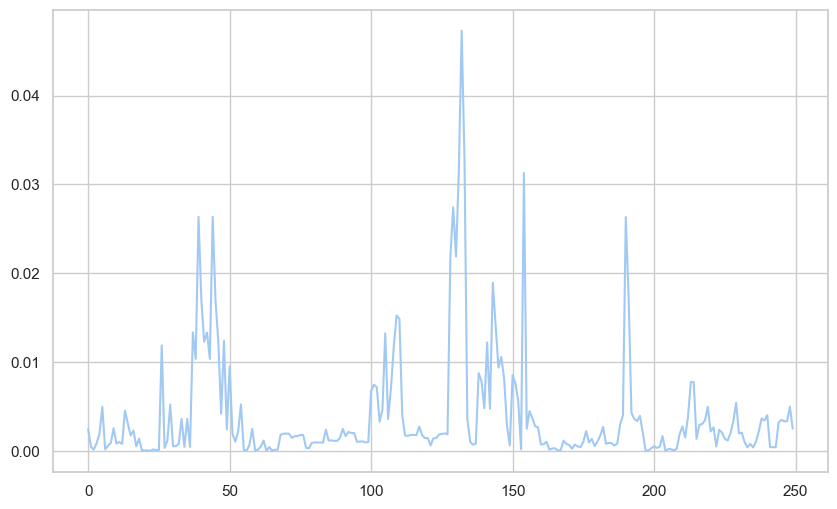

In [33]:
the_the_df = []
for country, projs in loaded_estimation_dict.items():
    for dollar_per_screening, _, money_spent in projs:
        pop, undiag, diag = the_df.loc[country]
        print(pop, diag, undiag)
        the_the_df.append([pop, diag, undiag, money_spent, dollar_per_screening])
DF = np.array(the_the_df)
plt.plot(DF[:,-2]/np.sum(DF[:,-2]));

In [12]:
from torch.optim import Adam
import torch
from torch import nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm

class ClassifierModule(nn.Module):
    def __init__(self, n_hidden):
        super().__init__()
        self.layers = nn.ModuleList()
        
        # simple CNN
        self.layers.append(
            nn.Sequential(
                nn.Linear(4, n_hidden),
                nn.ReLU(),
                nn.Linear(n_hidden, 1)
            )
        )

    def forward(self, X):
        for l in self.layers:
            X = l(X)
        return X


def train_model(n_hidden, lr, X_train, batch_size):
    max_steps = 1_000

    model = ClassifierModule(n_hidden).to(device)
    optim = Adam(model.parameters(), lr=lr)

    model.train()

    # Record start time
    # start_event = torch.cuda.Event(enable_timing=True)
    # end_event = torch.cuda.Event(enable_timing=True)
    # start_event.record()

    loss_list = []
    for step in tqdm(range(max_steps)):
        ix = torch.randint(0, len(X_train), (batch_size,))
        Xb, Yb = X_train[ix], y_train[ix]
        
        logits = model(Xb)
        loss = nn.MSELoss()(logits, Yb.float().view(-1, 1))
        loss_list.append(loss.item())
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        # # Record end time
        # end_event.record()
        # torch.cuda.synchronize()

        # Break if time limit exceeded
        # if start_event.elapsed_time(end_event) > max_time:
        #     break

        # Record start time for next iteration
        # end_event.record()
        # torch.cuda.synchronize()
        
        # if start_event.elapsed_time(end_event) > max_time:
        #     break
        
    return model, loss_list

X = DF[:, :-1]
y = DF[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

model, loss_list = train_model(1000, 0.01, X_train, 16)

100%|██████████| 1000/1000 [00:02<00:00, 426.65it/s]


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

X = DF[:, :-1]
y = DF[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model = MLPRegressor(hidden_layer_sizes=(1000, 1000, 1000, 1000), max_iter=1000)
model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(mean_squared_error(y_test, y_pred))
y_test - y_pred

565.3908756889753


array([-4.83727668e+00, -1.92220386e+00,  5.67356357e+00,  8.87236845e-01,
        3.83145773e+00,  1.46492055e+00, -5.87925877e-05, -9.83059162e+00,
        1.45663248e+02, -2.64631703e+00,  1.00775151e+01, -3.18302130e+00,
       -8.51321093e+00,  2.36154848e+01,  1.32116199e+00,  1.42310413e+00,
       -4.42622639e-01,  4.23803814e+00,  3.04579246e+00, -3.38336661e+01,
        2.06100111e+00, -3.34611218e+01,  3.99054989e+00,  3.06796677e+01,
        7.98827642e+00, -1.65526102e+01, -4.85906541e+00,  4.54969593e+00,
        1.80353223e+01,  5.10083024e+00,  5.98736803e+00, -1.18674986e+00,
       -5.44908821e+00, -1.72661764e+00, -2.70753511e+01,  5.44282165e+00,
        6.12072638e-01, -4.93239372e+00, -3.69249445e+00,  3.61256594e-01,
        3.96863900e+00,  5.49012882e+00, -1.12352590e+01, -1.26981179e+01,
       -9.32975184e+00,  6.73219832e+00, -1.22850841e+01, -2.24240266e+01,
        6.97133034e+00, -9.98966547e+00])

In [ ]:
X = data1[["Hypertension Mean", "Generalized Obesity Mean", "Abdominal Obesity Mean"]].values

y = data1["Diabetes Mean"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

_combined = np.concatenate((X_train, y_train[:,np.newaxis]), axis=1)

from sdv.datasets.local import load_csvs
from sdv.metadata import MultiTableMetadata
from sdv.multi_table import HMASynthesizer
metadata = MultiTableMetadata()

# data = pd.read_csv("X.csv", index_col=0)
data = pd.read_csv("X2.csv", index_col=0)
data = {"df1": data}

metadata.detect_from_dataframes(data)
metadata.update_column(table_name='df1', column_name='0', sdtype='numerical')
metadata.update_column(table_name='df1', column_name='1', sdtype='numerical')
metadata.update_column(table_name='df1', column_name='2', sdtype='numerical')
metadata.update_column(table_name='df1', column_name='3', sdtype='numerical')

synthesizer = HMASynthesizer(metadata)
synthesizer.fit(data)
synthetic_data = synthesizer.sample(1000)

X_synth = synthetic_data["df1"][["0","1","2"]]
y_synth = synthetic_data["df1"]["3"].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_synth)
X_test_scaled = scaler.transform(X_test)

# model = LinearRegression()
model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000)

model.fit(X_train_scaled, y_synth)
y_pred = model.predict(X_test_scaled)
print(mean_squared_error(y_test, y_pred))

y_test - y_pred

c:\Users\alexa\AppData\Local\Programs\Python\Python39\lib\site-packages\sdv\multi_table\base.py:81: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
Preprocess Tables:   0%|          | 0/1 [00:00<?, ?it/s]

Preprocess Tables: 100%|██████████| 1/1 [00:00<00:00, 28.65it/s]



Learning relationships:



Modeling Tables: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]
c:\Users\alexa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


7.9445105800722


array([ 4.82468222,  0.24942362, -0.24249592,  1.86395635,  1.44107493,
        5.13674117, -0.52522289])

In [93]:
def get_wdf(data):
    mask_approved = data["Board approval date"].notna()
    
    _approved_projects = np.bincount([int(re.split('-|/', i)[-1]) for i in data["Board approval date"][mask_approved]])[2002:]
    _approved_projects = np.append(_approved_projects, (22-len(_approved_projects))*[0])
    
    _dicter = {year: 0 for year in range(2002, 2024)}
    converter = {"USD": 6.93, "EUR": 7.46, "DKK": 1}
    for i, project in data[mask_approved].iterrows():
        try:
            year = int(re.split('-|/', project["Board approval date"])[-1])
            _dicter[year] += project["Total Revised WDF Contibution"] * converter[project["WDF Grant Currency"]]
        except: print(f"Error at project {i}")
        
    _approved_spending = list(_dicter.values())
    _spending_per_project = [x / (y+0.01) for x, y in zip(_approved_spending, _approved_projects)]
    return _approved_projects, _approved_spending, _spending_per_project

data_wdf = pd.read_excel('../Case/Milestones Case Data.xlsx', sheet_name=None)

Error at project 1739


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,7.000000e+00,1.500000e+01,2.000000e+01,3.000000e+01,3.700000e+01,4.800000e+01,5.200000e+01,4.400000e+01,4.400000e+01,3.700000e+01,...,4.300000e+01,5.900000e+01,6.300000e+01,5.700000e+01,3.100000e+01,1.700000e+01,2.600000e+01,2.100000e+01,1.500000e+01,1.200000e+01
1,2.358936e+07,3.458213e+07,2.228854e+07,4.033724e+07,5.006131e+07,9.742286e+07,7.550832e+07,7.995982e+07,6.652366e+07,4.979081e+07,...,6.016923e+07,7.122110e+07,8.794690e+07,9.320703e+07,7.199304e+07,1.109863e+08,1.399884e+08,1.196878e+08,7.001722e+07,9.615010e+07
2,3.365101e+06,2.303939e+06,1.113870e+06,1.344127e+06,1.352643e+06,2.029220e+06,1.451804e+06,1.816856e+06,1.511558e+06,1.345334e+06,...,1.398959e+06,1.206933e+06,1.395761e+06,1.634924e+06,2.321607e+06,6.524770e+06,5.382100e+06,5.696705e+06,4.664705e+06,8.005837e+06


In [146]:
data_tingin = [[str(i) for i in range(2002,2024)],
get_wdf(data_wdf["Projects"])[0],
[i/100_000 for i in get_wdf(data_wdf["Projects"])[1]],
[i/100_000 for i in get_wdf(data_wdf["Projects"])[2]]]

pd.DataFrame(zip(*data_tingin), columns=["Year", "Projects", "Spending", "Spending per project"]).to_csv("wdf_thing.csv")

Error at project 1739
Error at project 1739
Error at project 1739


Error at project 25


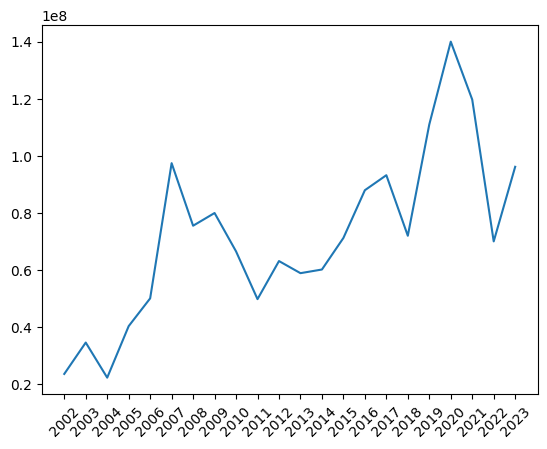

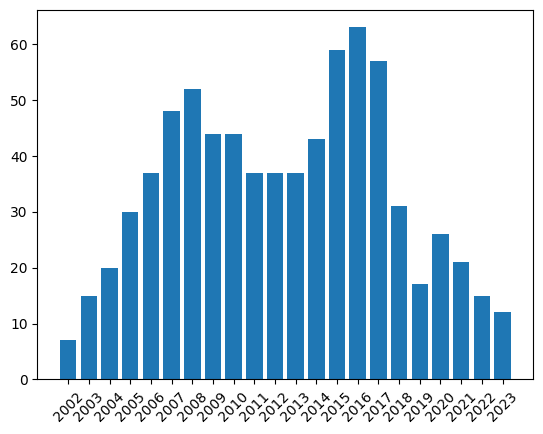

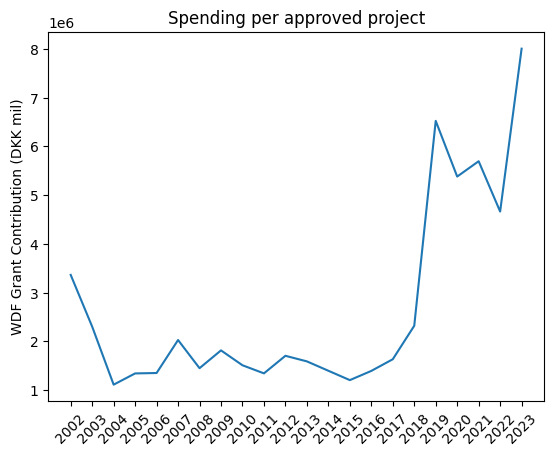

In [ ]:
def plot_wdf(data):    
    plt.plot(range(2002,2024), data[1])
    plt.xticks(range(2002, 2024), rotation=45)
    plt.show()

    plt.bar(range(2002,2024), data[0])
    plt.xticks(range(2002, 2024), rotation=45)
    plt.show()

    plt.plot(range(2002,2024), data[2])
    plt.xticks(range(2002,2024), rotation=45)
    plt.title("Spending per approved project")
    plt.ylabel("WDF Grant Contribution (DKK mil)")
    plt.show()


data_wdf = pd.read_excel('../Case/Milestones Case Data.xlsx', sheet_name=None)
plot_wdf(get_wdf(data_wdf["Projects"]))

Error at project 25


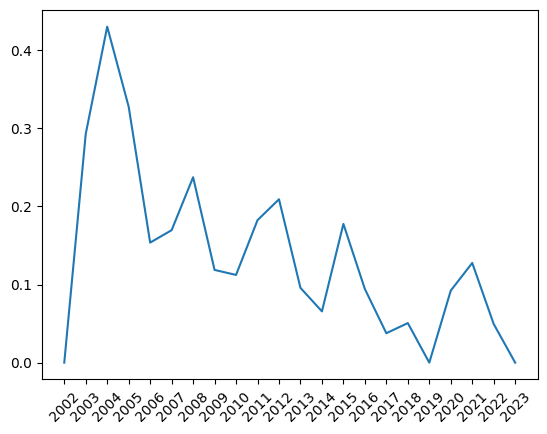

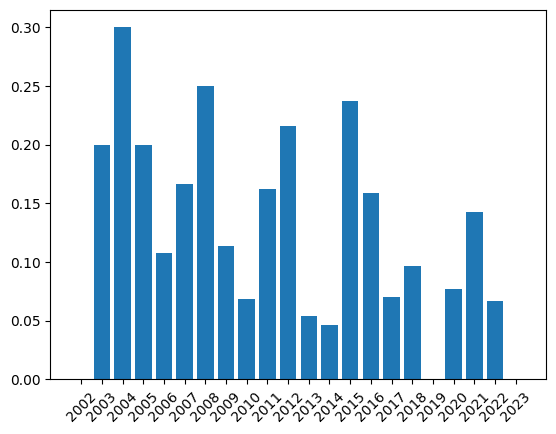

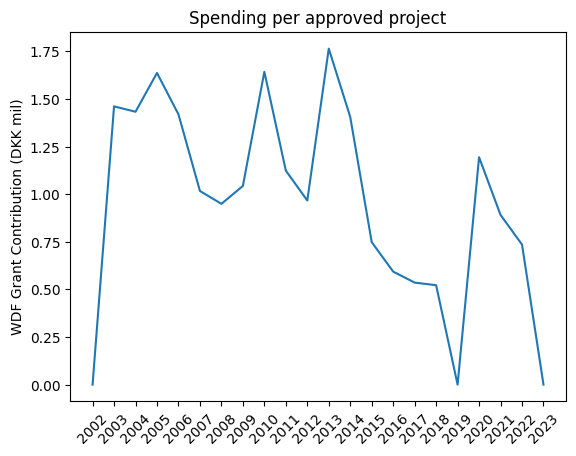

In [ ]:
data_india = data_wdf["Projects"][data_wdf["Projects"]["Countries"] == "India"]
plot_wdf([np.array(x)/np.array(y) for x,y in zip(get_wdf(data_india), get_wdf(data_wdf["Projects"]))])